# Adaption of CCN simulation

## Change-log
| Function | Detail | Date |
| ---- | ------------ | - |
| init_weights | sample them from prefect mean | 14.11 |
|  |  |  |
|  |  |  |

In [3]:
import argparse
import sys
import os
import json
import numpy as np

from ccn_envs import create_env
from datetime import datetime

from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns
 

## Helpers

In [4]:
def loss_fn(R_hat, R):
    """
    Mean Squared error
    R: Expected Rewards of all Agents
    S: Label
    """
    return 1/(len(R)) * np.sum(((R - R_hat) ** 2), axis=1)


def loss_gradients(R_hat, F, R):
    """
    Derivative of Mean Squared Error
    OMEGA: All Weights
    F: Feature matrix of all agents
    S: Label
    """
    dL = - 1 / (len(R)) * (R - (R_hat)) @ (2 * F)
    return dL

def clip_steps(position, grid_size):
    return np.clip(position, 0, grid_size - 1)

def draw_step(positions, prob_dist, rng):
    """@:return: (array [x1, x2]) the position"""
    return rng.choice(positions, p=prob_dist)



## Policy functions 

In [21]:
# Starting positions
def initialize_starting_position(fitness_m, n_agents, rho):
    """Init starting position based on last noise feature interpreted as quantile of fitness landscape"""
    quantiles = np.quantile(fitness_m, rho)
    all_positions = np.empty((n_agents, 2), dtype=int)
    for i, q in enumerate(quantiles):
        q_pos = np.where((np.round(q, 2) == np.round(fitness_m, 2)))
        q_pos_index = rng.integers(0, len(q_pos[0]))
        all_positions[i] = [q_pos[0][q_pos_index], q_pos[1][q_pos_index]]
    S = fitness_m[all_positions[:, 0], all_positions[:, 1]]
    return all_positions, S

def initialize_starting_position_fair(fitness_m, n_agents):
    """Init starting position based on last noise feature interpreted as quantile of fitness landscape"""
    all_positions = np.empty((n_agents, 2), dtype=int)
    quantile = np.quantile(fitness_m, 0.2)

    q_pos = np.where((np.round(quantile, 2) == np.round(fitness_m, 2)))
    for i in range(n_agents):
        q_pos_index = rng.integers(0, len(q_pos[0]))
        all_positions[i] = [q_pos[0][q_pos_index], q_pos[1][q_pos_index]]
    S = fitness_m[all_positions[:, 0], all_positions[:, 1]]
    return all_positions, S


def initialize_starting_position_random(fitness_m, n_agents):
    """Init starting position based on last noise feature interpreted as quantile of fitness landscape"""
    all_positions = rng.integers(0,1000, size=(n_agents, 2))
    S = fitness_m[all_positions[:, 0], all_positions[:, 1]]
    return all_positions, S


In [19]:
def local_search(env: np.array, agent_value, eta: float, position: np.array, steps, grid_size, tau, rng):
    """Stochastic Hill climbing OR random step (only if better)"""
    if eta >= rng.uniform(0, 1):
        rand_pos = rng.integers(0, grid_size, 2)
        rand_value = env[rand_pos[0]][rand_pos[1]]
        if rand_value > agent_value:
            return rand_pos.reshape(1, 2), np.array([1.]), False
    neighbour_states = [[clip_steps(position[0]+s[0], grid_size), clip_steps(position[1]+s[1], grid_size)] for s in steps]
    ind_values = np.array([env[p[0]][p[1]] for p in neighbour_states])
    ind_values_pb = softmax((ind_values / tau))
    return np.asarray(neighbour_states), ind_values_pb, agent_value == ind_values.max()


def create_feature_vector(n_agents, noise_features=2, rng=None):
    """Feature matrix F (agents x features): F[agent_i] = [gamma, eta, noise, rho]"""
    # Performance features
    gammas = rng.uniform(0, 1, size=n_agents)
    etas = rng.uniform(0, 1, size=n_agents)

    # Noise features
    f_noise = rng.choice(np.clip(rng.normal([0.3, 0.7], [0.1, 0.1], size=(n_agents, 2)), 0, 1).flat,
                         size=(n_agents, noise_features))

    # Add them together
    F = np.concatenate((np.stack((gammas, etas), axis=1), f_noise), axis=1)
    return F


def create_roleModel_features(n_roleModels, noise_features=2, rng=None):
    """Feature matrix F (n_roleModels x features): F[agent_i] = [gamma, eta, n0, n1, ...]"""
    # Performance features
    gammas = np.clip(rng.normal(0.8, 0.05, size=n_roleModels), 0, 1)
    etas = np.clip(rng.normal(0.8, 0.05, size=n_roleModels), 0, 1)

    # Noise features
    f_noise = np.concatenate((
        rng.choice(np.clip(rng.normal([0.3, 0.7], [0.1, 0.1], size=(n_roleModels, 2)), 0, 1).flat,
                   size=(n_roleModels, noise_features-1)),
        np.clip(
            rng.normal(0.3, 0.1, size=(n_roleModels, 1)),
            0, 1)
    ), axis=1)

    # Add them together
    F = np.concatenate((np.stack((gammas, etas), axis=1), f_noise), axis=1)
    return F


def initialize_role_models(fitness_m, n_roleModels):
    """Init less privileged agents, but explicitly good performance and traits"""
    if env_type == "NK":
        fitness_values = list(fitness_m.fitness_dict.values())
        fitness_values = (fitness_values - min(fitness_values)) 
        fitness_values /= max(fitness_values)
        quantile = np.quantile(fitness_values, 0.9)
        high_pos = np.where((np.round(quantile, 3) < np.round(fitness_values, 3)))[0]
        indexes = rng.choice(high_pos, size=n_roleModels)
        S = fitness_values[indexes]
        # states = np.array([env.get_scaled_fitness(np.array(list(f'{i:020b}')).astype(int)) for i in index])
        return S
        
    quantile = np.quantile(fitness_m, 0.9)
    high_pos = np.where((np.round(quantile, 3) < np.round(fitness_m, 3)))
    start_pos_index = rng.integers(0, len(high_pos[0]), n_roleModels)
    all_positions = np.stack((high_pos[0][start_pos_index], high_pos[1][start_pos_index]), axis=1)
    S = fitness_m[all_positions[:, 0], all_positions[:, 1]]
    return S


def intervention_gradient(OMEGA, F_rm, R_rm, b, n_roleModels, chosen_agents):
    """Calculate gradients for agents impacted by a mentor"""
    roleModels = rng.integers(n_roleModels, size=len(chosen_agents))
    R_hat_rm = OMEGA[chosen_agents] @ F_rm[roleModels].T + b
    W_grad = np.zeros_like(OMEGA)
    if len(R_hat_rm) > 0:
        grad_rm = loss_gradients(R_hat_rm, F_rm[roleModels], R_rm[roleModels])
        W_grad[chosen_agents] = grad_rm
    return W_grad


def run_intervention(n_roleModels, sigma, F, W, F_rm, R_rm, b, rng):
    """Run intervention which mentor impacts which less privileged agent"""
    chosen_agents = np.where(F[:, -1] < 0.5)[0]
    drawn_sigma = rng.random(size=len(chosen_agents))
    chosen_agents = chosen_agents[np.where(drawn_sigma <= sigma)[0]]
    return intervention_gradient(W, F_rm, R_rm, b, n_roleModels, chosen_agents)


def scale_eta(eta):
    """For eta in [0,1]"""
    return 0.1 * eta


def scale_gamma(gamma):
    """For gamma in [0,1]"""
    return 0.1 * gamma


### NK function

In [1]:
from ccn_envs import create_env, NK_landscape_loaded

In [5]:
def initialize_starting_position_NK_random(env, n_agents):
    states = np.round(rng.random((n_agents, env.N))).astype(int)
    scores = np.array([env.get_scaled_fitness(state) for state in states])
    return states, scores

def initialize_starting_position_NK_fair(env, n_agents):
    fitness_values = list(env.fitness_dict.values())
    fitness_values = (fitness_values - min(fitness_values)) 
    fitness_values /= max(fitness_values)
    quantile = np.quantile(fitness_values, 0.2)
    low_pos = np.where((np.round(quantile, 3) > np.round(fitness_values, 3)))[0]
    index = rng.choice(low_pos, size=n_agents).astype(int)
    S = fitness_values[index]
    states = np.array([np.array(list(f'{i:020b}')).astype(int) for i in index])
    return states, S

def initialize_starting_position_NK(env, n_agents, rho):
    fitness_values = list(env.fitness_dict.values())
    fitness_values = (fitness_values - min(fitness_values)) 
    fitness_values /= max(fitness_values)
    quantile = np.quantile(fitness_values, rho)
    S = np.zeros(n_agents)
    states = np.empty((n_agents, N)).astype(int)
    for _, q in enumerate(quantile):
        low_pos = np.where((np.round(q, 1) == np.round(fitness_values, 1)))[0]
        index = rng.choice(low_pos).astype(int)
        S[_] = fitness_values[index]
        states[_] = np.array(list(f'{index:020b}')).astype(int)
    return states, S

In [6]:
def local_search_nk(env, state, score, eta):
    if eta >= rng.uniform(0, 1):
        random_state = np.round(rng.random(env.N)).astype(int)
        if env.get_scaled_fitness(random_state) > score:
            return random_state, env.get_scaled_fitness(random_state)
    
    digit = rng.integers(0, env.N)
    new_state = state.copy()
    if state[digit] == 1:
        new_state[digit] = 0
    else:
        new_state[digit] = 1
    new_score = env.get_scaled_fitness(new_state)
    if new_score > score: 
        return new_state, env.get_scaled_fitness(state)
    return state, score
    

## Simulation

### Ideas for adjustement
* Always sample one agent to trust and only adjust social values for this agent (follow this agent)
    * Think of social imitation every iteration, just don't do it every time
    * Privilege would not break as easily, as privileged agents are chosen more often

In [111]:
def run_simulation(grid_size, n_agents, intervention, F, lr, max_iter, fitness_m, all_steps,
                   R_scale, beta, tau, intervention_start, sigma, rng):
    """Implements one full simulation run"""

    gammas = scale_gamma(F[:, 0])
    etas = scale_eta(F[:, 1])
    rho = F[:, -1]

    # Init agents based on privilege
    if env_type != "NK":
        all_positions, S = initialize_starting_position(fitness_m, n_agents, rho)
        # all_positions, S = initialize_starting_position_random(fitness_m, n_agents)
    else:
        all_positions, S = initialize_starting_position_NK(fitness_m, n_agents, rho)
        
    # Trait Learning
    W = rng.normal((max(S)-min(S))*0.5, 0.1, (n_agents, 4))  # *F.mean()/4
    A = W @ F.T

    # Simulation tracking variables
    intermediate_positions = np.zeros_like(all_positions)
    intermediate_S = np.zeros_like(S)
    S_history = np.empty((max_iter, n_agents))
    S_history[0] = S
    R = S

    W_history = np.empty((max_iter, F.shape[1]))
    W_history[0] = W.mean(axis=0)

    iteration = 1
    while iteration < max_iter:

        # 0. Calculate social values
        b = R.min()
        R_hat = W @ F.T + b
        Y = softmax((A/A.sum(axis=1)) / tau, axis=1)

        for agent_index in range(n_agents):
            # 1. Social learning
            if gammas[agent_index] >= rng.random():
                next_position = draw_step(all_positions, Y[agent_index], rng)
                if env_type != "NK":
                    next_S = fitness_m[next_position[0]][next_position[1]]
                else:
                    next_S = fitness_m.get_scaled_fitness(next_position)
            else:
                # 2. Local search
                if env_type != "NK":
                    positions, p_dist, use_social = local_search(fitness_m, S[agent_index], etas[agent_index],
                                                             all_positions[agent_index], all_steps,
                                                             grid_size, tau, rng)
                
                    next_position = draw_step(positions, p_dist, rng)
                    next_S = fitness_m[next_position[0]][next_position[1]]
                else:
                    next_position, next_S = local_search_nk(fitness_m, all_positions[agent_index], S[agent_index], etas[agent_index])
            
            # 3. safe values to update after all agents are through
            intermediate_positions[agent_index] = next_position
            intermediate_S[agent_index] = next_S
            
        # 4. Optimize W
        R_decay = R_scale[-iteration:] / R_scale[-iteration:].sum()
        R = R_decay @ S_history[:iteration]
        grad = loss_gradients(R_hat, F, R)
        W -= (lr * grad.T).T

        # 4.1 Gradient of intervention
        if intervention is True:
            if (intervention_start < iteration):
                grad_rm = run_intervention(n_roleModels, sigma, F, W, F_rm, R_rm, b, rng)
                W -= lr * grad_rm

        W_history[iteration] = W.mean(axis=0)
        A += beta * (W @ F.T - A)
        
        # 5. All agents walk at the same time
        S = intermediate_S
        all_positions = intermediate_positions
        S_history[iteration] = S

        iteration += 1

    loss = loss_fn(R_hat, R)
    return S_history, W, A, loss, W_history



In [112]:
def run_simulation_1Agent(grid_size, n_agents, intervention, F, lr, max_iter, fitness_m, all_steps,
                   R_scale, beta, tau, intervention_start, sigma, rng):
    """Implements one full simulation run"""

    gammas = scale_gamma(F[:, 0])
    etas = scale_eta(F[:, 1])
    rho = F[:, -1]

    # Init agents based on privilege
    if env_type != "NK":
        all_positions, S = initialize_starting_position(fitness_m, n_agents, rho)
        # all_positions, S = initialize_starting_position_random(fitness_m, n_agents)
    else:
        all_positions, S = initialize_starting_position_NK(fitness_m, n_agents, rho)
        
    # Trait Learning
    W = rng.normal((max(S)-min(S))*0.5, 0.1, (n_agents, 4))
    A = W @ F.T

    # Simulation tracking variables
    intermediate_positions = np.zeros_like(all_positions)
    intermediate_S = np.zeros_like(S)
    S_history = np.empty((max_iter, n_agents))
    S_history[0] = S
    R = S

    W_history = np.empty((max_iter, F.shape[1]))
    W_history[0] = W.mean(axis=0)

    iteration = 1
    while iteration < max_iter:

        # 0. Calculate social values
        b = R.min()
        R_hat = W @ F.T + b
        Y = softmax((A/A.sum(axis=1)) / tau, axis=1)

        leaders = np.zeros(n_agents, dtype=int)
        for agent_index in range(n_agents):
            # 1. Social learning
            leaders[agent_index] = rng.choice(np.arange(n_agents), p=Y[agent_index]).astype(int)
            if gammas[agent_index] >= rng.random():
                next_position = all_positions[leaders[agent_index]]
                if env_type != "NK":
                    next_S = fitness_m[next_position[0]][next_position[1]]
                else:
                    next_S = fitness_m.get_scaled_fitness(next_position)
            else:
                # 2. Local search
                if env_type != "NK":
                    positions, p_dist, use_social = local_search(fitness_m, S[agent_index], etas[agent_index],
                                                             all_positions[agent_index], all_steps,
                                                             grid_size, tau, rng)
                
                    next_position = draw_step(positions, p_dist, rng)
                    next_S = fitness_m[next_position[0]][next_position[1]]
                else:
                    next_position, next_S = local_search_nk(fitness_m, all_positions[agent_index], S[agent_index], etas[agent_index])
            
            # 3. safe values to update after all agents are through
            intermediate_positions[agent_index] = next_position
            intermediate_S[agent_index] = next_S
            
        # 4. Optimize W
        R_decay = R_scale[-iteration:] / R_scale[-iteration:].sum()
        R = R_decay @ S_history[:iteration]        
        grad = loss_gradients(R_hat[leaders], F[leaders], R[leaders])
        W -= (lr * grad.T).T

        # 4.1 Gradient of intervention
        if intervention is True:
            if (intervention_start < iteration):
                grad_rm = run_intervention(n_roleModels, sigma, F, W, F_rm, R_rm, b, rng)
                W -= lr * grad_rm

        W_history[iteration] = W.mean(axis=0)
        A += beta * (W @ F.T - A)
        
        # 5. All agents walk at the same time
        S = intermediate_S
        all_positions = intermediate_positions
        S_history[iteration] = S

        iteration += 1

    loss = loss_fn(R_hat, R)
    return S_history, W, A, loss, W_history



**Changes todo**:
* Weight init
* Gradient size


## Run simulation

In [80]:
import pickle

In [160]:
# file = "N20K5_5.pkl"
file = "N20K2_5.pkl"

with open(file, 'rb') as f:
    landscapes = pickle.load(f)

n_landscapes = int(str(file.split("_")[1]).split(".")[0])
N, K = str(file.split("_")[0])[1:].split("K")
N, K = int(N), int(K)

env_type = "NK"

In [9]:
env_type = "2D"
envs = ["MasonWatts", "Ackley", "DropWave"]


In [113]:
# Simulation parameter
seed = 0

grid_size = 1000
total_simulations = 300
max_iterations = 150
n_agents = 7


all_steps = np.array([[i, j] for i in np.arange(-1, 2) for j in np.arange(-1, 2)])

lr = 0.1
noise_features = 2  # Number of noise features (keep to 2)
beta = 0.5  # Learning rate for social influence matrix A
tau = 0.01  # Exploitation for social and individual optimization


intervention = False
n_roleModels = 2
sigma = 0.2  # Probability for mentor connections during continuous intervention
intervention_start = 50

# Label scaling
lambda_scale = 0.9  # Label decay
R_scale = lambda_scale ** np.arange(max_iterations - 1, -1, -1)


In [114]:
rng = np.random.default_rng(seed)

sys.stdout.write(f'\nSimulation is starting: {env_type} \n')
# Create environment
if env_type != "NK":
    fitness_matrices = [create_env(env, grid_size)[0] for env in envs]
else:
    fitness_matrices = landscapes

if intervention is True:
    F_rm = create_roleModel_features(n_roleModels, noise_features, rng)
    R_rm = initialize_role_models(fitness_m, n_roleModels)

    
# result saving
all_results = np.empty((total_simulations * n_agents, 13))  # Second param: How many vars to track
W_results = np.zeros((max_iterations, 4))

S_results = np.zeros(max_iterations)

# Start simulations
sys.stdout.write(f"\nIn total {total_simulations} simulations")
for _ in range(total_simulations):
    # Create traits
    if env_type == "NK":
        fitness_m = NK_landscape_loaded(N, K, fitness_matrices[rng.integers(len(envs))])
    else:
        fitness_m, env_title = create_env(envs[rng.integers(0, len(envs))], grid_size)
    F = create_feature_vector(n_agents=n_agents, noise_features=noise_features, rng=rng)

    S_history, W, A, loss, W_history = run_simulation_1Agent(grid_size=grid_size, n_agents=n_agents, intervention=intervention,
                                                      F=F, lr=lr, max_iter=max_iterations,
                                                      fitness_m=fitness_m, all_steps=all_steps, R_scale=R_scale,
                                                      beta=beta, tau=tau, intervention_start=intervention_start,
                                                      sigma=sigma, rng=rng)

    run_results = np.concatenate((F,
                                  W,
                                  S_history.max(axis=0).reshape(n_agents, 1),
                                  S_history.mean(axis=0).reshape(n_agents, 1),
                                  S_history[0].reshape(n_agents, 1),
                                  loss.reshape(n_agents, 1),
                                  A.mean(axis=0).reshape(n_agents, 1),
                                  ), axis=1)

    all_results[_*n_agents: _*n_agents+n_agents] = run_results

    W_results += W_history
    S_results += S_history.mean(axis=1)

    if (_+1) % 100 == 0:
        sys.stdout.write(f"\n Simulation: {_+1}")

W_results /= total_simulations
S_results /= total_simulations
sys.stdout.write(f"\nFinished successfully")



Simulation is starting: 2D 

In total 300 simulations
 Simulation: 100
 Simulation: 200
 Simulation: 300
Finished successfully

In [140]:
# Max, Mean, Start Value
all_results[:,8:11].mean(axis=0)

array([0.51439776, 0.36942364, 0.16677019])

Text(0, 0.5, 'Mean Score')

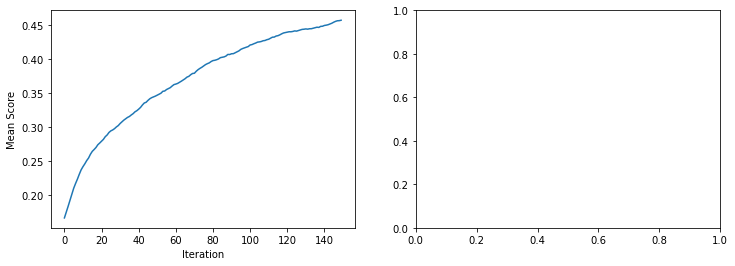

In [146]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(S_results)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Mean Score")



In [117]:
from scipy.stats import pearsonr

In [118]:
[pearsonr(all_results[:,i], all_results[:,9]) for i in range(4)]

[(0.01428451815322495, 0.5129555937025555),
 (0.1647562593546935, 3.017674885121075e-14),
 (0.04807674336799003, 0.027586618717034064),
 (0.07705850839239323, 0.0004086740054009852)]

## Visualize

In [119]:
weight_cols = ["social imitation $\gamma$", "random jumps $\eta$", "noise $\\nu$", "privilege $\\rho$"]

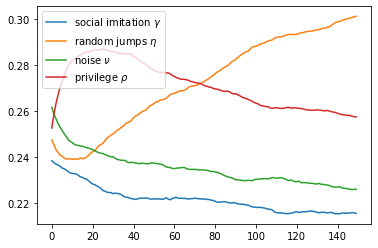

In [120]:
W_norm = W_results/ W_results.sum(axis=1).reshape(-1,1)
for i, col in enumerate(weight_cols):
    plt.plot(W_norm[:,i], label=col)
plt.legend()

In [121]:
W_results # / W_results.sum(axis=1).reshape(-1,1)

array([[0.06830053, 0.07089511, 0.07494537, 0.07236452],
       [0.06938103, 0.07168299, 0.07552624, 0.07545407],
       [0.07082826, 0.07272493, 0.07673449, 0.07861872],
       [0.07265289, 0.07435595, 0.07821618, 0.08192772],
       [0.07452551, 0.07603934, 0.07987119, 0.0852467 ],
       [0.07636014, 0.07803678, 0.08165635, 0.08854141],
       [0.07817556, 0.07973685, 0.08326271, 0.09160563],
       [0.07954604, 0.08117479, 0.08450153, 0.09427715],
       [0.08126603, 0.08315421, 0.08606731, 0.09712584],
       [0.08293663, 0.08514373, 0.08780455, 0.0999599 ],
       [0.08488605, 0.08708648, 0.08976461, 0.10277517],
       [0.08661819, 0.08897693, 0.09134991, 0.10507498],
       [0.08823195, 0.09071165, 0.09301042, 0.10743212],
       [0.0896221 , 0.09230715, 0.0946219 , 0.10961462],
       [0.09078309, 0.09402587, 0.09600377, 0.11156026],
       [0.09213846, 0.09533766, 0.09752819, 0.11352896],
       [0.09293822, 0.09650503, 0.09845025, 0.11505075],
       [0.09430756, 0.09819924,

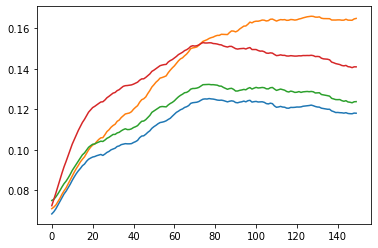

In [122]:
plt.plot(W_results)

In [125]:
np.sum(W_results[0] * 0.5)

0.14325276741136778

In [142]:
min(all_results[:,10])

0.0005142644903601838